Setup & Install Dependencies

In [ ]:
# Install all required libraries
!pip install tensorflow pandas numpy opencv-python scikit-learn matplotlib kaggle streamlit localtunnel

ERROR: Ignored the following versions that require a different python version: 0.55.2 Requires-Python <3.5
ERROR: Could not find a version that satisfies the requirement localtunnel (from versions: none)
ERROR: No matching distribution found for localtunnel


Upload Your Kaggle API Key

In [1]:
import os
from google.colab import files

print("Please upload your kaggle.json file:")
uploaded = files.upload()

if 'kaggle.json' in uploaded:
    print("Kaggle API key uploaded successfully!")

    # Set up the Kaggle directory and permissions
    !mkdir -p ~/.kaggle
    !mv kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json
else:
    print("File upload failed or was not 'kaggle.json'. Please try again.")

Please upload your kaggle.json file:


Saving kaggle.json to kaggle.json
Kaggle API key uploaded successfully!


Download & Prepare Data

In [5]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import zipfile
import kaggle

# --- Configuration ---
DATA_DIR = 'data'
KAGGLE_DATASET = 'jangedoo/utkface-new'
DATASET_ARCHIVE = os.path.join(DATA_DIR, 'utkface-new.zip')
IMAGE_DIR = os.path.join(DATA_DIR, 'utkface_aligned_cropped', 'UTKFace')
OUTPUT_CSV = os.path.join(DATA_DIR, 'labels.csv')

def download_and_extract():
    """Downloads and extracts the UTKFace dataset using the Kaggle API."""
    os.makedirs(DATA_DIR, exist_ok=True)
    if os.path.exists(IMAGE_DIR):
        print("Dataset already exists. Skipping download and extraction.")
        return

    print("Downloading dataset from Kaggle... (this may take a few minutes)")
    try:
        kaggle.api.dataset_download_files(KAGGLE_DATASET, path=DATA_DIR, unzip=False)
    except Exception as e:
        print(f"❌ Kaggle API Error: {e}")
        return

    print(f"Extracting {DATASET_ARCHIVE}...")
    try:
        with zipfile.ZipFile(DATASET_ARCHIVE, 'r') as zip_ref:
            zip_ref.extractall(DATA_DIR)
    except Exception as e:
        print(f"Extraction failed: {e}. Please delete the 'data' folder and try again.")
        return

    os.remove(DATASET_ARCHIVE)
    print("✅ Dataset ready.")

def mock_label_hair(age, gender):
    """MOCK function to simulate hair length labels."""
    return np.random.choice([0, 1], p=[0.3, 0.7]) if gender == 1 else np.random.choice([0, 1], p=[0.8, 0.2])

def create_labels_csv():
    """Parses filenames and creates a CSV with labels."""
    if not os.path.exists(IMAGE_DIR):
        print("❌ Error: Image directory not found. Download or extraction may have failed.")
        return

    print(f"Parsing filenames to create {OUTPUT_CSV}...")
    image_files = [f for f in os.listdir(IMAGE_DIR) if f.lower().endswith('.jpg')]
    records = []

    for filename in tqdm(image_files, desc="Processing files"):
        filepath = os.path.join(IMAGE_DIR, filename)
        try:
            parts = filename.split('_')
            if len(parts) >= 3:
                age, gender = int(parts[0]), int(parts[1])
                if 0 < age < 120 and gender in [0, 1]:
                    hair_length = mock_label_hair(age, gender)
                    records.append([filepath, age, gender, hair_length])
        except (ValueError, IndexError):
            continue

    if not records:
        print("\n❌ CRITICAL ERROR: No valid image files were found.")
        return

    df = pd.DataFrame(records, columns=['filepath', 'age', 'gender', 'hair_length'])
    df.to_csv(OUTPUT_CSV, index=False)
    print(f"\n✅ Successfully created labels CSV with {len(df)} entries.")
    print("\n--- Data Sample ---")
    print(df.head())

# Run the data preparation
download_and_extract()
create_labels_csv()

Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
Extracting data/utkface-new.zip...
✅ Dataset ready.
Parsing filenames to create data/labels.csv...


Processing files: 100%|██████████| 23708/23708 [00:00<00:00, 34604.98it/s]



✅ Successfully created labels CSV with 23708 entries.

--- Data Sample ---
                                            filepath  age  gender  hair_length
0  data/utkface_aligned_cropped/UTKFace/47_0_0_20...   47       0            1
1  data/utkface_aligned_cropped/UTKFace/39_1_4_20...   39       1            1
2  data/utkface_aligned_cropped/UTKFace/67_0_3_20...   67       0            0
3  data/utkface_aligned_cropped/UTKFace/84_1_0_20...   84       1            0
4  data/utkface_aligned_cropped/UTKFace/1_1_2_201...    1       1            1


Define Model Training Code

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt

# --- Configuration ---
IMG_SIZE = 128
BATCH_SIZE = 64
EPOCHS = 25 # Using the improved 25 epochs
DATA_CSV = os.path.join('data', 'labels.csv')
MODELS_DIR = 'models'
OUTPUT_DIR = 'output'

os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)

def build_model(task):
    """Builds a model with fine-tuning enabled."""
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)

    if task == 'age':
        output_layer = Dense(1, activation='linear', name='age_output')(x)
        loss = 'mse'
        metrics = ['mae']
    else: # For gender and hair
        output_layer = Dense(1, activation='sigmoid', name=f'{task}_output')(x)
        loss = 'binary_crossentropy'
        metrics = ['accuracy']

    model = Model(inputs=base_model.input, outputs=output_layer)

    # Fine-Tuning Strategy: Unfreeze top 20 layers
    for layer in base_model.layers[-20:]:
        layer.trainable = True

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss=loss,
        metrics=metrics
    )
    return model

def plot_history(history, task):
    """Plots training and validation history."""
    metric = 'accuracy' if task in ['gender', 'hair'] else 'mae'
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history[metric], label=f'Training {metric}')
    plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
    plt.title(f'{task.capitalize()} Model {metric.capitalize()}')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{task.capitalize()} Model Loss')
    plt.legend()

    plt.tight_layout()
    plot_path = os.path.join(OUTPUT_DIR, f'{task}_training_history.png')
    plt.savefig(plot_path)
    plt.show() # Show the plot inline in Colab
    print(f"Saved training plot to {plot_path}")

def train(task):
    """Main training function."""
    print(f"--- Starting training for task: {task} ---")
    df = pd.read_csv(DATA_CSV)

    y_col = {'age': 'age', 'gender': 'gender', 'hair': 'hair_length'}[task]

    train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

    train_datagen = ImageDataGenerator(
        rescale=1./255, rotation_range=20, width_shift_range=0.2,
        height_shift_range=0.2, shear_range=0.2, zoom_range=0.2,
        horizontal_flip=True, fill_mode='nearest'
    )
    val_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df, x_col='filepath', y_col=y_col,
        target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode='raw'
    )

    validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_df, x_col='filepath', y_col=y_col,
        target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode='raw'
    )

    model = build_model(task)

    lr_scheduler = ReduceLROnPlateau(
        monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1
    )

    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=EPOCHS,
        callbacks=[lr_scheduler]
    )

    model_path = os.path.join(MODELS_DIR, f'{task}_model.keras')
    model.save(model_path)
    print(f"Model saved to {model_path}")

    plot_history(history, task)
    print(f"--- Finished training for task: {task} ---\n")

print("Training functions defined successfully.")

Training functions defined successfully.


Train the 'Age' Model

--- Starting training for task: age ---
Found 18966 validated image filenames.
Found 4742 validated image filenames.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
297/297 ━━━━━━━━━━━━━━━━━━━━ 121s 342ms/step - loss: 586.8121 - mae: 18.0190 - val_loss: 264.6708 - val_mae: 12.1992 - learning_rate: 1.0000e-04
Epoch 2/25
297/297 ━━━━━━━━━━━━━━━━━━━━ 84s 284ms/step - loss: 161.8893 - mae: 9.4896 - val_loss: 226.0580 - val_mae: 11.0927 - learning_rate: 1.0000e-04
Epoch 3/25
297/297 ━━━━━━━━━━━━━━━━━━━━ 85s 286ms/step - loss: 143.4597 - mae: 8.8644 - val_loss: 169.1780 - val_mae: 9.3297 - learning_rate: 1.0000e-04
Epoch 4/25
297/297 ━━━━━━━━━━━━━━━━━━━━ 84s 282ms/step - loss: 138.9631 - mae: 8.7097 - val_loss: 172.4666 - val_mae: 9.3177 - learning_rate: 1.0000e-04
Epoch 5/25
297/297 ━━━━━━━━━━━━━━━━━━━━ 85s 285ms/step - loss: 132.9834 - mae: 8.4810 - val_loss: 116.0270 - val_mae: 7.7284 - learning_rate: 1.0000e-04
Epoch 6/25
297/297 ━━━━━━━━━━━━━━━━━━━━ 84s 283ms/step - loss: 132.0455 - mae: 8.3985 - val_loss: 130.4562 - val_mae: 8.0981 - learning_rate: 1.0000e-04
Epoch 7/25
297/297 ━━━━━━━━━━━━━━━━━━━━ 84s 283ms/step - loss: 119.2583 - mae:

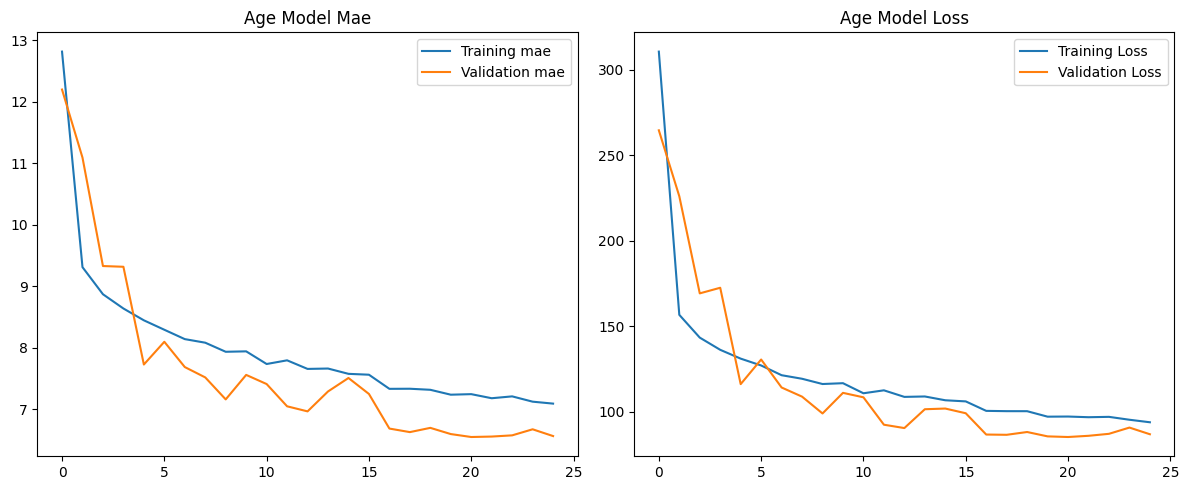

Saved training plot to output/age_training_history.png
--- Finished training for task: age ---



In [8]:
train('age')

Train the 'Gender' Model

--- Starting training for task: gender ---
Found 18966 validated image filenames.
Found 4742 validated image filenames.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
297/297 ━━━━━━━━━━━━━━━━━━━━ 134s 376ms/step - accuracy: 0.7121 - loss: 0.5677 - val_accuracy: 0.7638 - val_loss: 0.6025 - learning_rate: 1.0000e-04
Epoch 2/25
297/297 ━━━━━━━━━━━━━━━━━━━━ 85s 286ms/step - accuracy: 0.8163 - loss: 0.3990 - val_accuracy: 0.7916 - val_loss: 0.7181 - learning_rate: 1.0000e-04
Epoch 3/25
297/297 ━━━━━━━━━━━━━━━━━━━━ 85s 286ms/step - accuracy: 0.8345 - loss: 0.3636 - val_accuracy: 0.8007 - val_loss: 0.6482 - learning_rate: 1.0000e-04
Epoch 4/25
297/297 ━━━━━━━━━━━━━━━━━━━━ 84s 283ms/step - accuracy: 0.8482 - loss: 0.3437 - val_accuracy: 0.8524 - val_loss: 0.3859 - learning_rate: 1.0000e-04
Epoch 5/25
297/297 ━━━━━━━━━━━━━━━━━━━━ 85s 286ms/step - accuracy: 0.8599 - loss: 0.3214 - val_accuracy: 0.8340 - val_loss: 0.4286 - learning_rate: 1.0000e-04
Epoch 6/25
297/297 ━━━━━━━━━━━━━━━━━━━━ 85s 286ms/step - accuracy: 0.8609 - loss: 0.3170 - val_accuracy: 0.8741 - val_loss: 0.3145 - learning_rate: 1.0000e-04
Epoch 7/25
297/297 ━━━━━━━━━━━━━━━━━━━━ 84s 2

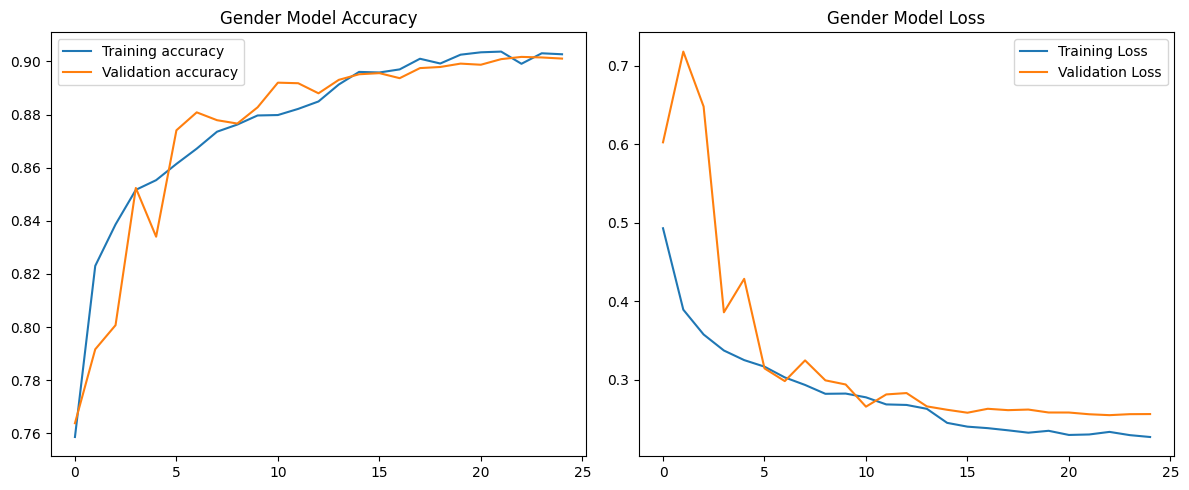

Saved training plot to output/gender_training_history.png
--- Finished training for task: gender ---



In [6]:
train('gender')

Train the 'Hair' Model

--- Starting training for task: hair ---
Found 18966 validated image filenames.
Found 4742 validated image filenames.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
297/297 ━━━━━━━━━━━━━━━━━━━━ 113s 336ms/step - accuracy: 0.5818 - loss: 0.7205 - val_accuracy: 0.5981 - val_loss: 0.7152 - learning_rate: 1.0000e-04
Epoch 2/25
297/297 ━━━━━━━━━━━━━━━━━━━━ 85s 285ms/step - accuracy: 0.6373 - loss: 0.6435 - val_accuracy: 0.6461 - val_loss: 0.6621 - learning_rate: 1.0000e-04
Epoch 3/25
297/297 ━━━━━━━━━━━━━━━━━━━━ 84s 283ms/step - accuracy: 0.6429 - loss: 0.6355 - val_accuracy: 0.6335 - val_loss: 0.7061 - learning_rate: 1.0000e-04
Epoch 4/25
297/297 ━━━━━━━━━━━━━━━━━━━━ 84s 284ms/step - accuracy: 0.6677 - loss: 0.6217 - val_accuracy: 0.6303 - val_loss: 0.6925 - learning_rate: 1.0000e-04
Epoch 5/25
297/297 ━━━━━━━━━━━━━━━━━━━━ 85s 285ms/step - accuracy: 0.6668 - loss: 0.6238 - val_accuracy: 0.6727 - val_loss: 0.6405 - learning_rate: 1.0000e-04
Epoch 6/25
297/297 ━━━━━━━━━━━━━━━━━━━━ 84s 283ms/step - accuracy: 0.6665 - loss: 0.6195 - val_accuracy: 0.6622 - val_loss: 0.6577 - learning_rate: 1.0000e-04
Epoch 7/25
297/297 ━━━━━━━━━━━━━━━━━━━━ 84s 2

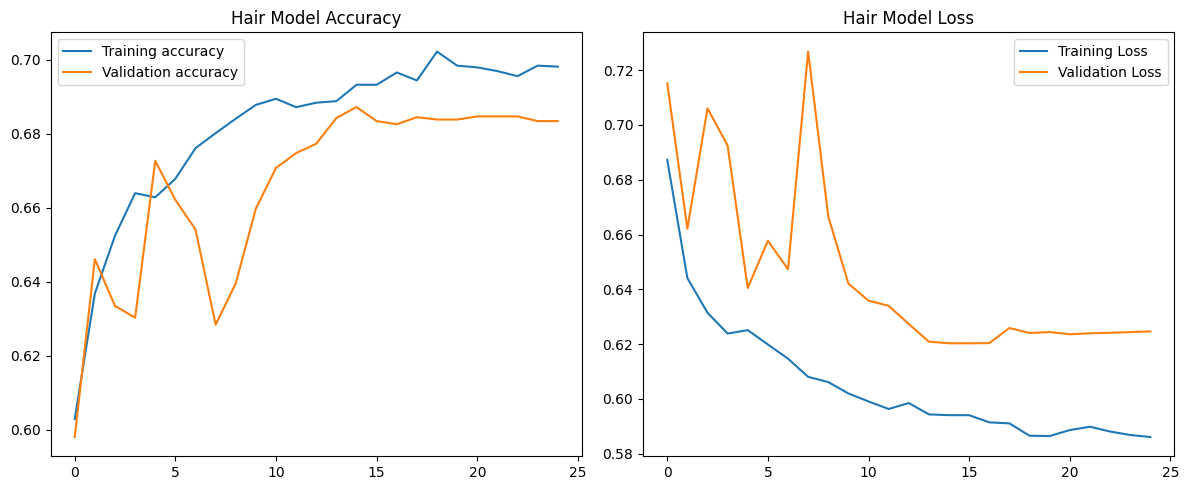

Saved training plot to output/hair_training_history.png
--- Finished training for task: hair ---



In [7]:
train('hair')

Write the Streamlit App Code

In [9]:
%%writefile app.py
import streamlit as st
from PIL import Image
import numpy as np
import tensorflow as tf
import cv2
import os

# --- Configuration ---
MODELS_DIR = 'models'
IMG_SIZE = 128

# Set page config
st.set_page_config(page_title="Gender Prediction Project", layout="wide")

# --- Model Loading ---
@st.cache_resource
def load_all_models():
    """Load all three trained models."""
    try:
        age_model = tf.keras.models.load_model(os.path.join(MODELS_DIR, 'age_model.keras'))
        gender_model = tf.keras.models.load_model(os.path.join(MODELS_DIR, 'gender_model.keras'))
        hair_model = tf.keras.models.load_model(os.path.join(MODELS_DIR, 'hair_model.keras'))
        return age_model, gender_model, hair_model
    except Exception as e:
        st.error(f"Error loading models: {e}")
        return None, None, None

# --- Image Preprocessing ---
def preprocess_image(image):
    """Preprocesses the image for model prediction."""
    img = np.array(image.convert('RGB'))
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    return img

# --- Final Logic Function ---
def get_final_prediction(age, gender, hair):
    """Applies the project's core logic and returns all results."""
    predicted_age = int(np.round(age[0][0]))
    gender_prob = gender[0][0]
    hair_prob = hair[0][0]

    display_gender = "Female" if gender_prob > 0.5 else "Male"
    display_hair = "Long" if hair_prob > 0.5 else "Short"

    if 20 <= predicted_age <= 30:
        final_prediction = "Female" if display_hair == "Long" else "Male"
        reason = f"Rule Applied: Age ({predicted_age}) is between 20-30, so prediction is based on hair length."
    else:
        final_prediction = display_gender
        reason = f"Rule Applied: Age ({predicted_age}) is outside 20-30, so prediction is based on predicted biological gender."

    return predicted_age, display_gender, display_hair, final_prediction, reason, gender_prob, hair_prob

# --- Streamlit App Layout ---
st.title("🧓 Long Hair Identification Project 🧑‍🦰")
st.markdown("This app predicts gender based on a special set of rules involving age and hair length.")

age_model, gender_model, hair_model = load_all_models()

if age_model:
    uploaded_file = st.file_uploader("Choose an image of a person's face...", type=["jpg", "jpeg", "png"])

    if uploaded_file is not None:
        image = Image.open(uploaded_file)

        col1, col2 = st.columns(2)

        with col1:
            st.image(image, caption='Uploaded Image', use_container_width=True)

        with col2:
            st.write("### Prediction Results")
            with st.spinner('Analyzing the image...'):
                processed_image = preprocess_image(image)
                pred_age = age_model.predict(processed_image)
                pred_gender = gender_model.predict(processed_image)
                pred_hair = hair_model.predict(processed_image)

                p_age, p_gender, p_hair, final_pred, reason, gender_prob, hair_prob = get_final_prediction(pred_age, pred_gender, pred_hair)

                st.info(f"**Final Prediction:** `{final_pred}`")
                st.markdown("---")
                st.write("#### Intermediate Model Outputs:")
                st.write(f"**Predicted Age:** {p_age} years")
                st.write(f"**Predicted Biological Gender:** {p_gender} (Confidence: {gender_prob:.2f})")
                st.write(f"**Predicted Hair Length:** {p_hair} (Confidence: {hair_prob:.2f})")
                st.markdown("---")
                st.write("#### Reasoning:")
                st.warning(reason)
else:
    st.warning("Models are not loaded. Please train them first.")

Writing app.py
